# Exponential Growth and Decline Models

In this chapter, we'll fit our data to a few models that are useful for predicting both exponential growth and decline.

## Exponential growth and decline

Before working with our data, we'll cover the basics of exponential growth and decline. In the most general form, we can write an exponential function as the following:

$$f(x) = ab^x$$

Where `a` is the initial starting value, `b` is the growth rate (must be greater than 0), and `x` is time. The starting value will decrease towards 0 when `b` is less than 1 and explode to infinity when greater than 1. At every time period, the previous value increases/decreases by multiplying it by `b`. Exponential growth and decline examples are shown below, each starting with the same initial value.

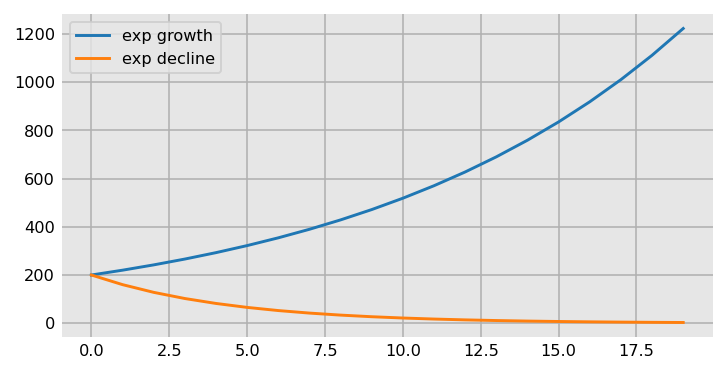

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dashboard.mplstyle')

a = 200
x = np.arange(20)

# growth at 10% each day
y_inc = a * 1.1 ** x
# decline at 20% each day
y_dec = a * 0.8 ** x

fig, ax = plt.subplots()
ax.plot(y_inc, label='exp growth')
ax.plot(y_dec, label='exp decline')
ax.legend();

## Modeling total cases with scipy's `least_squares`

Let's use this simple approach to model the cumulative total cases for different areas. Let's read in our data and select cases in Texas as a pandas Series. We'll set the last overall date as September 1, 2020.

In [2]:
from prepare import PrepareData
data = PrepareData(download_new=False).run()
usa_cases = data['usa_cases']
usa_cases = usa_cases.loc[:'2020-09-01']
texasc = usa_cases['Texas']
texasc = texasc[texasc > 0]
texasc.head()

2020-03-05     3
2020-03-06     4
2020-03-07     8
2020-03-08    11
2020-03-09    13
Name: Texas, dtype: int64

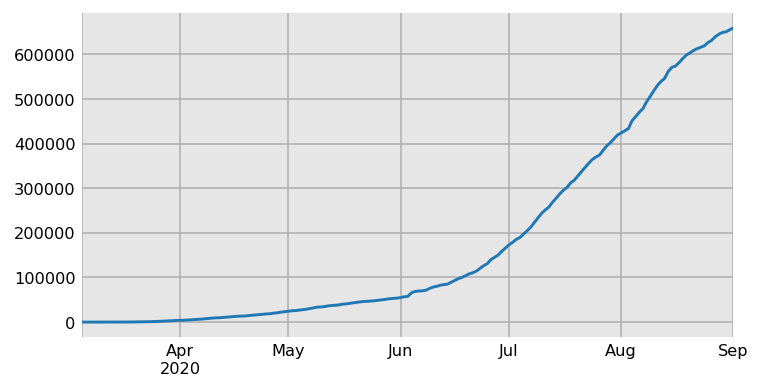

In [3]:
texasc.plot();

To use this simple exponential model, we create a function that returns its value when given the x-values and the two parameters, `a` and `b`.

In [4]:
def simple_exp(x, a, b):
    """
    Simple exponential model
    
    Parameters
    ----------
    x : array of x-values, usually just np.arange(len(y))
    
    a : initial starting value
    
    b : growth rate
    
    Returns
    -------
    Evaluated function values as an array
    """
    return a * b ** x

To find the optimal values of the parameters `a` and `b`, we'll use scipy's `least_squares` function, found in the `optimize` module. In order to use it, we must define a function that accepts the parameters as a sequence as the first argument, as well as the data `x` and `y` as separate arguments. It will also accept `model`, which is the function that computes the actual value of the model. This function must return the error between the function value and the y-values. 

In [5]:
def optimize_func(params, x, y, model):
    """
    Function to be passed as first argument to least_squares
    
    Parameters
    ----------
    params : sequence of parameter values for model
    
    x : x-values from data
    
    y : y-values from data
    
    model : function to be evaluated at x with params
    
    Returns
    -------
    Error between function and actual data
    """
    y_pred = model(x, *params)
    error = y - y_pred
    return error

The `least_squares` function requires an initial guess of the parameters, `x0`. It attempts to find the values of the parameters that minimize the total squared error (the "least squares"). We must use the `args` keyword parameter to pass in the `x`, `y`, and `model` as a tuple. The general form of `least_squares` will look like this:

```python
least_squares(optimize_func, initial_guess, args=(x, y, model))
```

Since we are modeling exponential growth, `a` must be positive and `b` must be greater than 1. We'll initially guess 1 for each of the parameters. It's also important to provide boundaries for the parameter values by setting `bounds` to a two-item tuple of the lower and upper bounds, which are each themselves tuples the same length as the number of parameters. We allow `a` to be between 1 and infinity and `b` to be between 1 and 10. The `least_squares` function returns the results as an object containing lots of information about the optimization. Here, we assign it to the `res` variable name.

Note that we use the variable name `p0` and not `x0`. In the next chapter, we'll use another model containing the parameter name `x0`. This is an unfortunate name collision, so we choose to always use `p0` for the initial parameter values ("parameter zero") passed to `least_squares`.

In [7]:
from scipy.optimize import least_squares
y = texasc.values
x = np.arange(len(y))
lower_bounds = 1, 1
upper_bounds = np.inf, 10
bounds = lower_bounds, upper_bounds
p0 = 1, 1
res = least_squares(optimize_func, p0, args=(x, y, simple_exp), bounds=bounds)

The optimal values of the parameters are found in the `x` attribute.

In [8]:
res.x

array([1.15567853e+04, 1.02367319e+00])

The model found the growth rate to be around 2.3% per day beginning at an initial value of 13,500. Let's pass `simple_exp` the x-values and estimated parameters to generate the predicted values and plot them against the actual data.

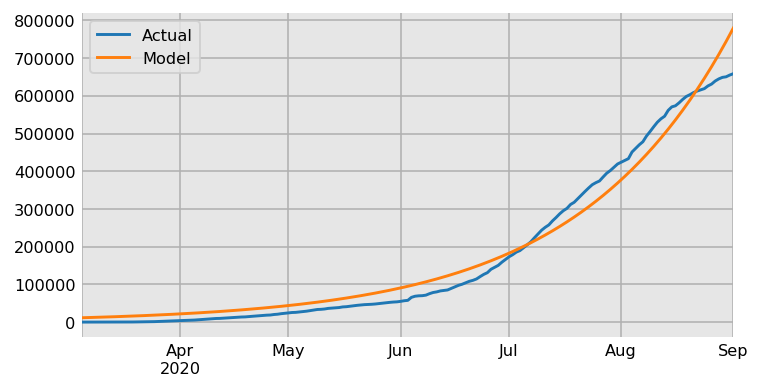

In [9]:
y_pred = simple_exp(x, *res.x)
s_pred = pd.Series(data=y_pred, index=texasc.index)
texasc.plot(label="Actual")
s_pred.plot(label="Model").legend();

### Predicting unseen data

While the model matches the data somewhat well, the utility of our model depends on data it has yet to see. Let's build our model on data only up to May 30th and then make predictions for all of the dates. As you can see below, the true evaluation for this model is substantially worse.

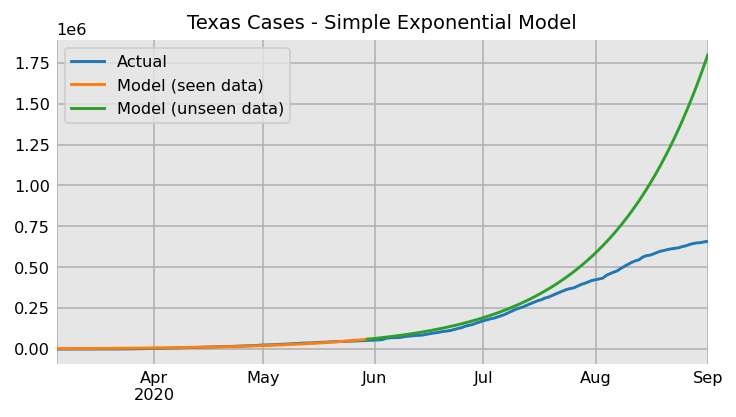

In [10]:
y = texasc[:'2020-05-30']
x = np.arange(len(y))
res = least_squares(optimize_func, p0, args=(x, y, simple_exp), bounds=bounds)
x_pred = np.arange(len(texasc))
y_pred = simple_exp(x_pred, *res.x)
s_pred = pd.Series(data=y_pred, index=texasc.index)
texasc.plot(label="Actual")
s_pred[:'2020-05-30'].plot(label="Model (seen data)", 
                        title="Texas Cases - Simple Exponential Model")
s_pred['2020-05-30':].plot(label="Model (unseen data)").legend();

### Optimizing `least_squares`

There are many options in `least_squares` to alter the way the parameters are found. By default, `least_squares` finds a set of parameters that minimize the sum of squared errors (SSE) between the actual values and the model. It does so using a complex iterative algorithm that slowly changes the parameters each iteration calculating a new SSE. If the change in the SSE is below a pre-defined threshold, the algorithm stops and returns the parameters. The main two thresholds are given by the following parameters:

* `ftol` - change in SSE (default 1e-8)
* `xtol` - change in parameter values (default 1e-8)

Some other useful parameters:

* `max_nfev` - Maximum number of function evaluations before algorithm stops (default: number of observations * 100)
* `verbose` - Set to 1 for printed results and 2 for detailed results (default: 0).

Let's run `least_squares` setting `verbose` to 1 to view the results of the above process. 

In [11]:
res = least_squares(optimize_func, p0, args=(x, y, simple_exp), bounds=bounds, verbose=1)
res.x

`ftol` termination condition is satisfied.
Function evaluations 40, initial cost 2.6895e+10, final cost 4.5480e+08, first-order optimality 6.77e+06.


array([2.73651373e+03, 1.03669508e+00])

It took around 40 function evaluations (on my machine) to meet the `ftol` condition for stopping. Let's reduce its tolerance to a smaller numbers and re-run the fit.

In [12]:
res = least_squares(optimize_func, p0, args=(x, y, simple_exp), bounds=bounds, verbose=1, ftol=1e-14)
res.x

`xtol` termination condition is satisfied.
Function evaluations 46, initial cost 2.6895e+10, final cost 4.5480e+08, first-order optimality 2.44e+02.


array([2.73649991e+03, 1.03669516e+00])

A few more iterations were run to meet the new threshold (`xtol` this time). The values for the parameters are essentially unchanged. In the exercise below, you'll use `kwargs` to pass any extra arguments to `least_squares`. Note that the default value for `bounds` is `(-np.inf, np.inf)` regardless of the number of parameters to be fit.

### Exercise 18

<span style="color:green; font-size:16px">Write a function that accepts a Series of data, the last date to use for training the model, the evaluation function, bounds, and initial guess of the parameters. Assume that `optimize_func` has already been defined and is available in your namespace. Have it build the model up to the last date. Return the array of the fitted model parameters.</span>

In [13]:
def train_model(s, last_date, model, bounds, p0, **kwargs):
    """
    Train a model using scipy's least_squares function
    to find the fitted parameter values
    
    Parameters
    ----------
    s : pandas Series with data used for modeling
    
    last_date : string of last date to use for model
    
    model : function returning model values
    
    bounds : two-item tuple of lower and upper bounds of parameters
    
    p0 : tuple of initial guess for parameters
    
    kwargs : extra keyword arguments forwarded to the least_squares function
                (ftol, xtol, max_nfev, verbose)
    
    Returns
    -------
    numpy array: fitted model parameters
    """
    y = s[:last_date]
    x = np.arange(len(y))
    res = least_squares(optimize_func, p0, args=(x, y, model), bounds=bounds)
    return res.x

Let's use this function to build the model trained only up to May 15 and output the fitted parameters.

In [14]:
from solutions import train_model
last_date = '2020-05-15'
params = train_model(texasc, last_date=last_date,
                     model=simple_exp, p0=p0, bounds=bounds)
params

array([1.52536795e+03, 1.04817478e+00])

## Part 5: Automate daily predictions

### Exercise 19

<span style="color:green; font-size:16px">Write a function that returns the daily predicted cases given the model, fitted parameters, number of observations trained, and number of predictions desired. Remember that the model provides cumulative values, not daily.</span>

In [15]:
def get_daily_pred(model, params, n_train, n_pred):
    """
    Makes n_pred daily predictions given a trained model
    
    Parameters
    ----------
    model : model that has already been trained
    
    params : parameters of trained model
    
    n_train : number of observations model trained on
    
    n_pred : number of predictions to make
    
    Returns
    -------
    numpy array: predicted daily values
    """
    x_pred = np.arange(n_train - 1, n_train + n_pred)
    y_pred = model(x_pred, *params)
    y_pred_daily = np.diff(y_pred)
    return y_pred_daily

Let's use this function to predict the next 50 daily new cases in Texas.

In [16]:
from solutions import get_daily_pred
n_train = len(texasc.loc[:last_date])
y_pred_daily = get_daily_pred(simple_exp, params, n_train, n_pred=50).round()
y_pred_daily

array([ 2075.,  2175.,  2280.,  2389.,  2505.,  2625.,  2752.,  2884.,
        3023.,  3169.,  3321.,  3481.,  3649.,  3825.,  4009.,  4202.,
        4405.,  4617.,  4839.,  5073.,  5317.,  5573.,  5842.,  6123.,
        6418.,  6727.,  7051.,  7391.,  7747.,  8120.,  8511.,  8921.,
        9351.,  9802., 10274., 10769., 11288., 11831., 12401., 12999.,
       13625., 14281., 14969., 15691., 16446., 17239., 18069., 18940.,
       19852., 20808.])

We can use these daily values to calculate the cumulative total. First we find the last known total.

In [ ]:
last_actual_value = texasc['2020-5-15']
last_actual_value

Adding this value to the cumulative sum gives us the predicted cumulative total.

In [ ]:
y_pred_cumulative = y_pred_daily.cumsum() + last_actual_value
y_pred_cumulative

### Exercise 20

<span style="color:green; font-size:16px">Write a function that returns the cumulative predicted values starting with the first day after the last date used in the model. Return a Series with an index that has the correct dates.</span>

In [21]:
def get_cumulative_pred(last_actual_value, y_pred_daily, last_date):
    """
    Returns the cumulative predicted values beginning with the
    first date after the last known date
    
    Parameters
    ----------
    last_actual_value : int, last recorded value
    
    y_pred_daily : array of predicted values
    
    last_date : string of last date used in model
    
    Returns
    -------
    Series with correct dates in the index
    """
    y_pred = last_actual_value + y_pred_daily.cumsum()
    last_date = pd.Timestamp(last_date) + pd.Timedelta('1D')
    index = pd.date_range(last_date, periods= len(y_pred))
    return pd.Series(y_pred, index=index)

Using the predicted daily values for the cumulative total resolves the issue we had with using the smoothed data which cumulative values did not exactly align with the actual last cumulative value.

In [24]:
#from solutions import get_cumulative_pred
last_actual_value = texasc.loc['2020-5-15']
s_pred_cumulative = get_cumulative_pred(last_actual_value, y_pred_daily, "2020-05-15")
s_pred_cumulative.tail()

2020-06-30    370611.0
2020-07-01    388680.0
2020-07-02    407620.0
2020-07-03    427472.0
2020-07-04    448280.0
Freq: D, dtype: float64

### Exercise 21

<span style="color:green; font-size:16px">Write a function that plots the original and predicted Series. Only plot the original data up to the last predicted date.</span>

In [27]:
def plot_prediction(s, s_pred, title=""):
    """
    Plots both the original and predicted values 
    
    Parameters
    ----------
    s : Series of original data
    
    s_pred : Series of predictions
    
    title : title of plot
    
    Returns
    -------
    None
    """
    last_pred_date = s_pred.index[-1]
    ax = s.loc[:last_pred_date].plot(label='Actual')
    s_pred.plot(label='Prediction')
    ax.legend()
    ax.set_title(title)

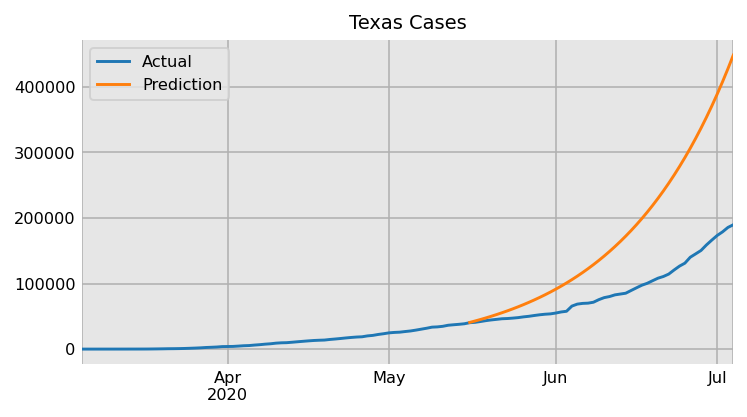

In [28]:
#from solutions import plot_prediction
plot_prediction(texasc, s_pred_cumulative, title="Texas Cases")

Let's put all of our work together into a single function that smooths, predicts, and plots the results.

### Exercise 22

<span style="color:green; font-size:16px">Use the `smooth`, `train_model`, `get_daily_pred`, `get_cumulative_pred` and `plot_prediction` functions to build a model and plot it. Have it return the array of fitted parameter values and the array of daily predicted values as a two-item tuple. The `start_date` is used to select the beginning of the modeling period (which will be useful when we model new waves).</span>

In [29]:
from solutions import smooth

def predict_all(s, start_date, last_date, n_smooth, n_pred, model, 
                bounds, p0, title="", **kwargs):
    """
    Smooth, train, predict, and plot a Series of data

    Parameters
    ----------
    s : pandas Series with data used for modeling

    start_date : string of first date to use for model

    last_date : string of last date to use for model

    n_smooth : number of points of data to be used by lowess function

    n_pred : number of predictions to make

    model : function returning model values

    bounds : two-item tuple of lower and upper bounds of parameters

    p0 : tuple of initial guess for parameters

    title : title of plot

    kwargs : extra keyword arguments forwarded to the least_squares function
                (bounds, ftol, xtol, max_nfev, verbose)

    Returns
    -------
    Array of fitted parameters
    """
    # Smooth up to the last date
    s_smooth = smooth(s[:last_date], n=n_smooth)
    
    # Filter for the start of the modeling period
    s_smooth = s_smooth[start_date:]
    
    pass # your code here

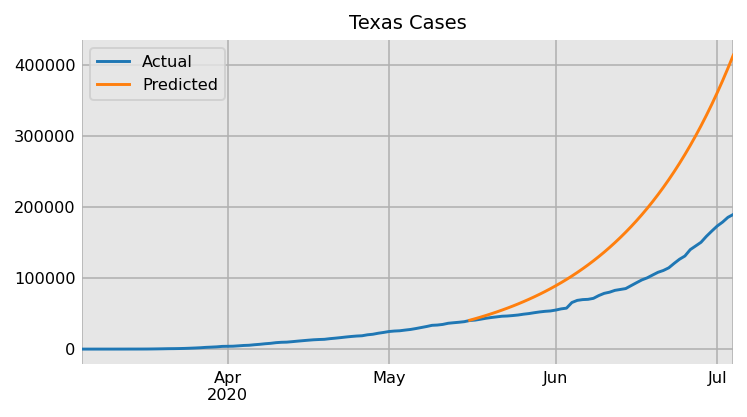

In [30]:
from solutions import predict_all
bounds = (1, 1), (np.inf, 10)
p0 = 1, 1
params, y_pred = predict_all(texasc, start_date=None, last_date="2020-05-15", n_smooth=15, 
                             n_pred=50, model=simple_exp, bounds=bounds, 
                             p0=p0, title="Texas Cases")

### Continuous growth with $e$

Our data is reported once per day, but we can think of the growth/decline as continuously happening. For continual growth processes, we use the mathematical constant $e$ (2.718...), which represents the limit to the growth rate if measured in infinitesimally small intervals, as opposed to once per day. Our model changes to:

$$f(x) = a e^{bx}$$

Where `a` and `b` still represent the initial value and growth rate, but `b` can now be negative or positive. A negative value of `b` results in exponential decline, while a positive value as exponential growth. In this formulation, `b` will approximately equal one less than its value in the first model (assuming `b` is fairly small). For instance, in our very first plot in this chapter, we used a value of 1.1 for `b` which represented a constant 10% increase each day. Using 10% continuous growth with the above formula (setting `b = 0.1`) yields similar results. Both formulations of the exponential model will work similarly.

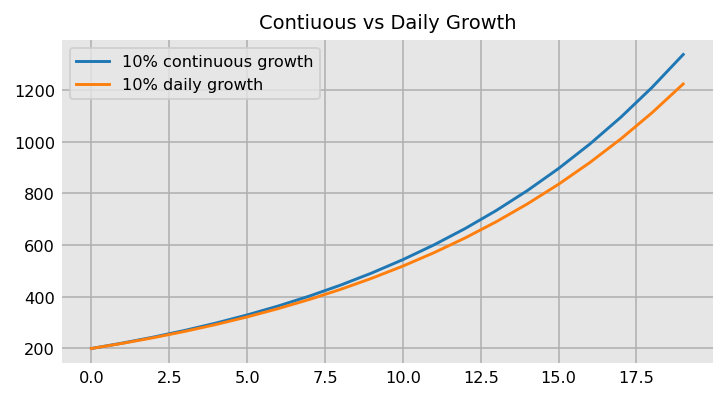

In [31]:
x = np.arange(20)
a = 200
b_old = 1.1
b_new = b_old - 1
y_old = a * b_old ** x
y_new = a * np.exp(b_new * x)

fig, ax = plt.subplots()
ax.set_title('Contiuous vs Daily Growth')
ax.plot(y_new, label='10% continuous growth')
ax.plot(y_old, label='10% daily growth')
ax.legend();

Let's build a predictive model with this new formulation in the same manner as before.

In [32]:
def simple_exp_cont(x, a, b):
    """
    Simple exponential model using continuous growth
    
    Parameters
    ----------
    x : array of x-values, usually just np.arange(len(y))
    
    a : initial starting value
    
    b : growth rate
    """
    return a * np.exp(b * x)

We'll change the bounds to adapt to this new formulation and then run `predict` to build and plot the model.

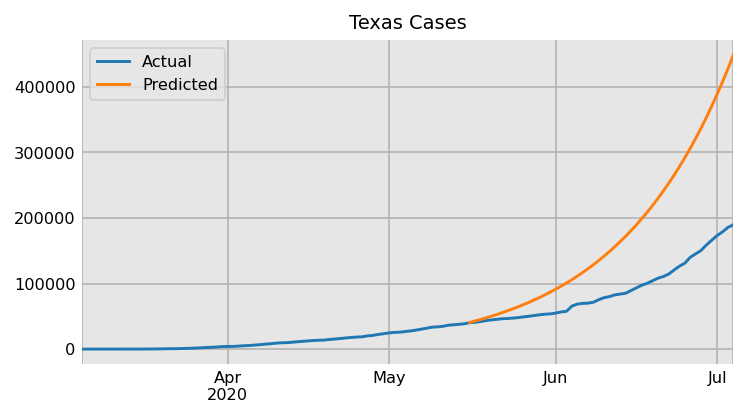

In [33]:
bounds = [1, 0.001], [10_000, 0.1]
p0 = 1, .01
predict_all(texasc,  start_date=None, last_date="2020-05-15", n_smooth=0.15, n_pred=50, 
            model=simple_exp_cont, bounds=bounds, p0=p0, title="Texas Cases");

The main issue with nearly all simple exponential models is that the actual growth rate changes over time. With our coronavirus data, the total deaths/cases is capped by the world's population, so cannot explode to infinity.

## Modeling exponential decline

It is common for the spread of pandemics throughout a population to begin with exponential growth, but then decrease until there is little/steady growth. Take a look at the plot below showing cases from Italy from March 20 through June 1. Exponential growth took place beginning in March, before a long slowdown began in early to mid April.

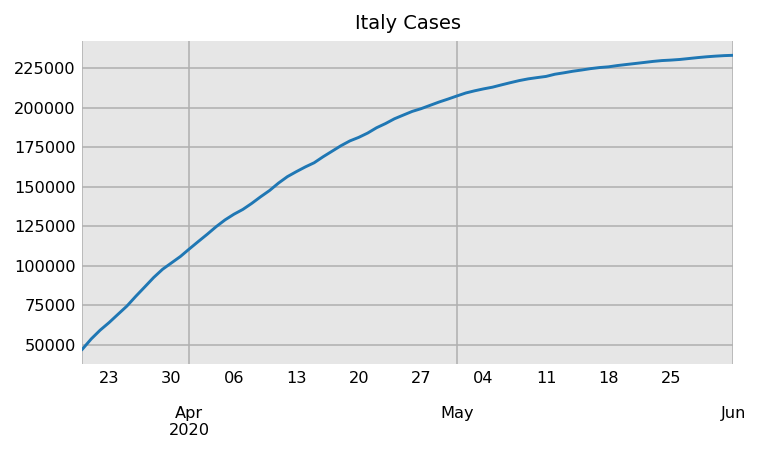

In [34]:
italyc = data['world_cases']['Italy']
italyc = italyc['2020-03-20':'2020-06-01']
italyc.plot(title="Italy Cases");

### Attempt to fit an exponential model

Let's use the `predict_all` function to fit our simple exponential model to Italy's data, giving it data through the beginning of April.

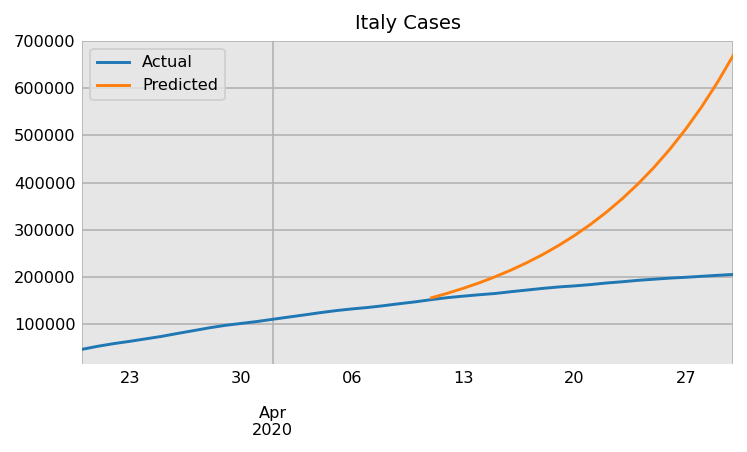

In [35]:
predict_all(italyc, start_date=None, last_date="2020-04-10", n_smooth=15, n_pred=20, 
            model=simple_exp_cont, bounds=bounds, p0=p0, title="Italy Cases");

### Increasing exponential decline

Clearly, we have the wrong choice of model. Our simple approach is only good for modeling exponential growth in the beginning but not during the slowdown. Our model can be transformed so that it becomes **decreasing exponential decline**, (when the values head towards 0), by selecting `b` that is less than 1 (or less than 0 in the second (continuous) formulation). 

The issue here is that our data is not decreasing to 0, but increasing towards an asymptote.  This is referred to as **increasing exponential decline**. The values increase, but do so at slower and slower rates as time goes on. If we multiply the decreasing exponential decline model by -1, we get the desired shape. Let's create an example by choosing a negative value for `a`.

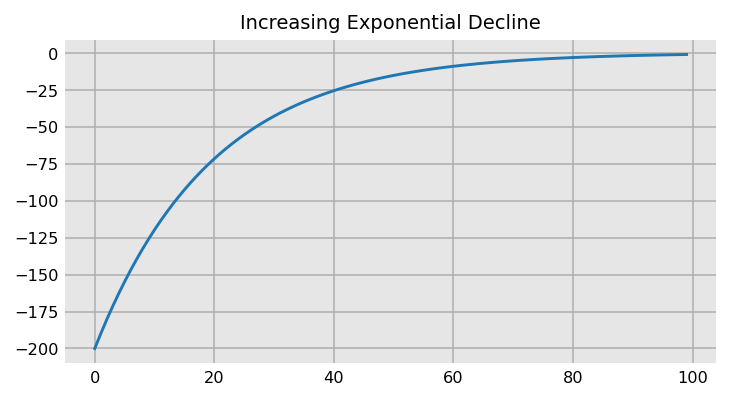

In [36]:
a = -200
b = .95
x = np.arange(100)
y = a * b ** x
fig, ax = plt.subplots()
ax.plot(y)
ax.set_title('Increasing Exponential Decline');

Since our data doesn't start off negative, we can add a new parameter, `c`, to shift the values upwards. Our new model becomes:

$$f(x) = ab^x + c$$

or 


$$f(x) = ae^{bx} + c$$

This will move the asymptote from 0 to `c` with the initial value now at `a + c`. For increasing exponential decline, `a` will always be negative and `b` less than 1. Let's shift the above graph up 500 units and add a second line with a smaller growth rate. It's important to note that a smaller growth rate results in a faster increase when modeling increasing exponential decline.

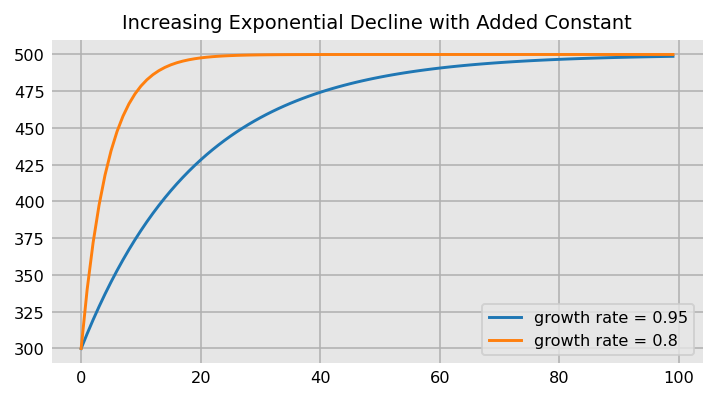

In [37]:
a = -200
b = 0.95
b2 = 0.8
c = 500
x = np.arange(100)
y = a * b ** x + c
y2 = a * b2 ** x + c

fig, ax = plt.subplots()
ax.plot(y, label=f'growth rate = {b}')
ax.plot(y2, label=f'growth rate = {b2}')
ax.set_title('Increasing Exponential Decline with Added Constant')
ax.legend();

Let's use this model for the currently selected cases in Italy using the following function to represent this new model.

In [ ]:
def exp_decline(x, a, b, c):
    """
    Simple exponential decline model
    
    Parameters
    ----------
    x : array of x-values, usually just np.arange(len(y))
    
    a : initial value
    
    b : growth rate
    
    c : vertical shift
    """
    return a * b ** x + c

We must change our bounds in order for this model to work. Here, `a` must be negative, `b` between 0 and 1, and `c` positive. We set the bounds for both `a` and `c` to be a very wide interval as we do not know the final total of cases in Italy. Let's use the `predict_all` function to build a model using data up through April 10.

In [ ]:
bounds = [-1000000, .1, 0], [-1, 1, np.inf]
p0 = -1000, .5, 100
predict_all(italyc, start_date=None, last_date="2020-04-10", n_smooth=15, n_pred=30, 
            model=exp_decline, bounds=bounds, p0=p0, title="Italy Cases");

The shape of the model looks good and the predictions are decent. Below, we build the same model using continuous growth.

In [ ]:
def exp_decline_cont(x, a, b, c):
    """
    Simple exponential decline with continuous growth
    
    Parameters
    ----------
    x : array of x-values, usually just np.arange(len(y))
    
    a : initial value
    
    b : growth rate
    
    c : vertical shift
    """
    return a * np.exp(b * x) + c

The bounds for the growth rate must be set to be negative.

In [ ]:
bounds = [-1000000, -1, 0], [-1, 0, np.inf]
p0 = -1, -1, 1
predict_all(italyc['2020-03-10':], start_date=None, last_date="2020-04-20", n_smooth=15, n_pred=30, 
            model=exp_decline_cont, bounds=bounds, p0=p0, title="Italy Cases");

## Exponential Function Summary

The four kinds of exponential functions are summarized below:

In [ ]:
def exp_explained(x, a, b, ax, title):
    y = a * b ** x
    ax.plot(y)
    ax.set_title(title)

x = np.arange(50)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
fig.suptitle('Exponential Function Summary: $ab^x$', y=.98, fontsize='x-large')
y = exp_explained(x, 1, 1.04, ax1, "Increasing exponential growth a > 0, b > 1")
y = exp_explained(x, 1, .94, ax2, "Decreasing exponential decline a > 0, b < 1")
y = exp_explained(x, -1, 1.04, ax3, "Decreasing exponential growth a < 0, b > 1")
y = exp_explained(x, -1, .94, ax4, "Increasing exponential decline in a < 0, b < 1")

The same models using continuous growth are plotted below:

In [ ]:
def exp_e_explained(x, a, b, ax, title):
    y = a * np.exp(b * x)
    ax.plot(y)
    ax.set_title(title)

x = np.arange(50)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
fig.suptitle('Exponential Function Summary: $ae^{bx}$', y=.98, fontsize='x-large')
y = exp_e_explained(x, 1, .04, ax1, "Increasing exponential growth a > 0, b > 0")
y = exp_e_explained(x, 1, -.04, ax2, "Decreasing exponential decline a > 0, b < 0")
y = exp_e_explained(x, -1, .04, ax3, "Decreasing exponential growth a < 0, b > 0")
y = exp_e_explained(x, -1, -.04, ax4, "Increasing exponential decline in a < 0, b < 0")